# Region Perturbation POC

Compared to previous notebooks, this notebook should integrate inpainting for the first time as a perturbation technique to the pixel-flipping/region perturbation algorithm.

## LRP

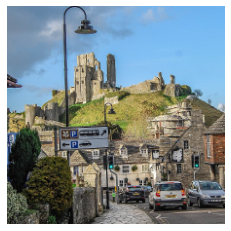

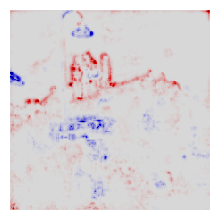

In [1]:
%load_ext autoreload
%autoreload 2

from typing import Callable, Dict, List, Tuple, Union

import numpy
import torch
import torchvision
from matplotlib import pyplot as plt

import lrp.plot
import lrp.rules as rules
from lrp import image
from lrp.core import LRP
from lrp.filter import LayerFilter
from lrp.rules import LrpEpsilonRule, LrpGammaRule, LrpZBoxRule, LrpZeroRule
from lrp.zennit.types import AvgPool, Linear

# Input data
# Image is in RGB mode with range [0,1]
img_bgr_hwc_float_0_1: numpy.array = image.load_img_norm_zero_one('../../data/castle.jpg')
X = lrp.norm.ImageNetNorm.transform(img_bgr_hwc_float_0_1)
# Simulate batch by adding a new dimension
X = torch.unsqueeze(X, 0)

plt.axis('off')
lrp.plot.plot_imagenet(X)

# Model
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.zeros(*shape))
high: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.ones(*shape))

# Init layer filter
vgg16_target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type: LayerFilter = LayerFilter(model)
filter_by_layer_index_type.set_target_types(vgg16_target_types)

name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0.25}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

lrp_instance: LRP = LRP(model)
lrp_instance.convert_layers(name_map)
R: torch.Tensor = lrp_instance.relevance(X)
lrp_instance.heatmap(R, width=2, height=2)

## Region Perturbation

Try Region Perturbation with inpainting enabled.

Finished '_flip' in 0.9968 secs
Finished '_flip' in 1.0129 secs
Finished '_flip' in 1.0248 secs
Finished '_flip' in 1.0128 secs
Finished '_flip' in 1.0180 secs
Finished '_flip' in 1.0552 secs
Finished '_flip' in 1.0154 secs
Finished '_flip' in 1.0069 secs
Finished '_flip' in 1.0128 secs
Finished '_flip' in 1.0147 secs
Finished '_flip' in 1.2643 secs
Finished '_flip' in 1.0010 secs
Finished '_flip' in 1.0071 secs
Finished '_flip' in 0.9986 secs
Finished '_flip' in 1.0035 secs
Finished '__call__' in 16.4998 secs


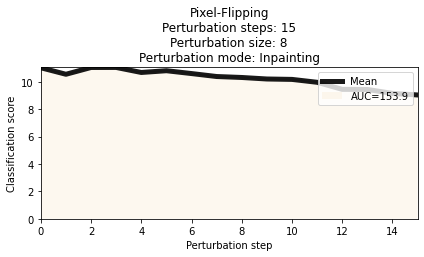

In [2]:
# %%script false --no-raise-error

# Parameters for cell: X, R, lrp_instance
from pf.perturbation_modes.constants import PerturbModes
from pf.pixel_flipping import PixelFlipping

perturbation_steps: int = 100
perturbation_size: int = 8

pixel_flipping: PixelFlipping = PixelFlipping(perturbation_steps=perturbation_steps,
                                              perturbation_size=perturbation_size,
                                              perturb_mode=PerturbModes.INPAINTING)
input: torch.Tensor = X.clone().detach()

# Enable reproducibility
torch.manual_seed(42)

relevance_scores: torch.Tensor = R.clone().detach()

# Function should return the (single-class) classification score for the given input to measure the difference between flips.
forward_pass: Callable[[torch.Tensor], float] = lambda input_nchw: lrp_instance.model(input_nchw)[:,483]

# Run Pixel-Flipping algorithm
pixel_flipping(input, relevance_scores, forward_pass)

# Plot classification scores throughout perturbation steps
title: str = f'''Pixel-Flipping
Perturbation steps: {pixel_flipping.perturbation_steps}
Perturbation size: {pixel_flipping.perturbation_size}
Perturbation mode: {pixel_flipping.perturb_mode}'''
xlabel: str = 'Perturbation step'
ylabel: str = 'Classification score'
pixel_flipping.plot_class_prediction_scores(title=title, xlabel=xlabel, ylabel=ylabel)

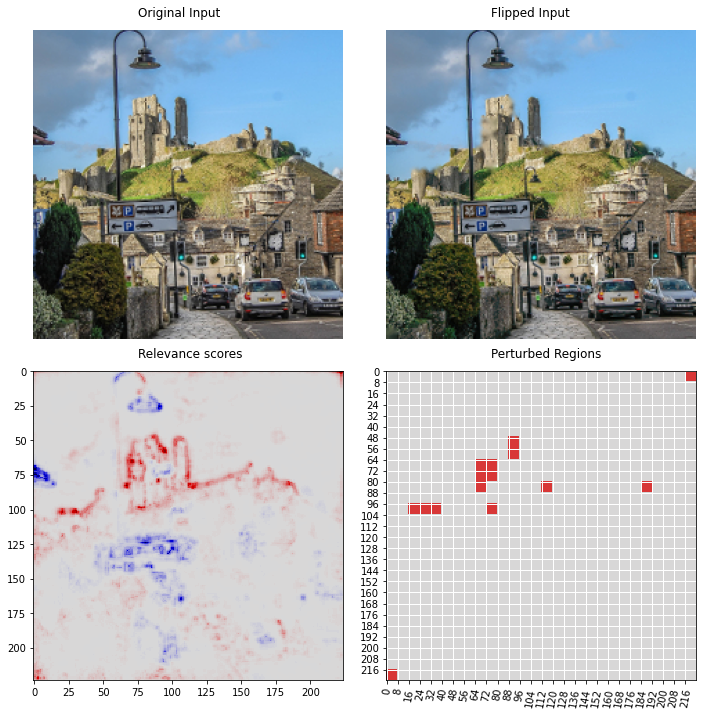

In [3]:
pixel_flipping.plot_image_comparison()